In [1]:
import astropy.constants as const
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as mcolors
import cmasher as cmr
import numpy as np
import sunpy.map
import pfsspy
from pfsspy import coords
from pfsspy import tracing
from pfsspy.sample_data import get_gong_map
import astropy.units as units
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import frames
import scipy
import pickle
#from my_func import *
import warnings
warnings.simplefilter('ignore')
#spacepy.toolbox.update(leapsecs=True)

import astropy.coordinates
from astropy.time import Time
import astropy.units as u

import sunpy.io.fits

ngrid = 20
lonbox = 20
latbox = 20
nrho = 35  #Number of cells in the radial direction to calculate the PFSS solution on.
rss = 2.5  #Radius of the source surface, as a fraction of the solar radius.

In [2]:
#matplotlib settings

%matplotlib inline
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 20
plt.rcParams['agg.path.chunksize'] = 20000

#set Jupyter notebook cells to 100% screen size
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML(data="""
<style> div#notebook-container { width: 99%; } div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style>
"""))

# provide input 

In [3]:
cr = 2243  # Carrington Rotation, 2243->(2021-04-14), 2245->(2021-06-07), 2246->(2021-07-04)
date = '2021/4/17'
ss_footp_lon = 270  # Carrington longitude of footpoint on SS, which we want to backmap to photosphere
ss_footp_lat = 0   # latitute of footpoint on SS

# load hmi map and calculate PFSS solution

In [4]:
# downloading hmi map and calculating the PFSS solution

time = a.Time(date, date)
pfname =  f'/home/chospa/solar_mach/pfss/PFSS_output_{time.start.datetime.date()}_CR{cr}_SS{rss}_nrho{nrho}.p'
try: # check if PFSS file already exists locally:
    with open(pfname, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        output = u.load()
    print('Found pickled PFSS file')
except FileNotFoundError: # if not existent, download MHI mag, calc. PFSS, and save as picle file for next time
    series = a.jsoc.Series('hmi.synoptic_mr_polfil_720s')
    crot = a.jsoc.PrimeKey('CAR_ROT', cr)
    result = Fido.search(time, series, crot, a.jsoc.Notify("chospa@utu.fi"))
    files = Fido.fetch(result)
    hmi_map = sunpy.map.Map(files[0])
    pfsspy.utils.fix_hmi_meta(hmi_map)
    print('Data shape: ', hmi_map.data.shape)
    hmi_map = hmi_map.resample([360, 180]*units.pix)
    print('New shape: ', hmi_map.data.shape)
    pfss_input = pfsspy.Input(hmi_map, nrho, rss)
    output = pfsspy.pfss(pfss_input)
    with open(pfname, 'wb') as f:
        pickle.dump(output, f)


Found pickled PFSS file


# trace field lines from SS to 1 Rs

## trace for the whole map (lower field line resolution) 

In [39]:
pfname =  f'/home/chospa/solar_mach/pfss/PFSS_fieldlines_grid_{ngrid}_{time.start.datetime.date()}_CR{cr}_SS{rss}_nrho{nrho}.p'
try:  # check if fieldlines file exists
    with open(pfname, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        field_lines = u.load()
    print('Found pickled PFSS fieldlines file')
except FileNotFoundError: # if not existent, calc. field lines, and save as pickle file for next time
    tracer = tracing.PythonTracer()
    r = 1.5*const.R_sun
    lat0 = np.linspace(-np.pi / 2, np.pi / 2, ngrid, endpoint=False)
    lon0 = np.linspace(0, 2*np.pi, ngrid, endpoint=False)
    lat1, lon1 = np.meshgrid(lat0, lon0, indexing='ij')
    lat, lon = lat1.ravel()*units.rad, lon1.ravel()*units.rad
    seeds = SkyCoord(lon, lat, r, frame=output.coordinate_frame)
    field_lines = tracer.trace(seeds, output)
    with open(pfname, 'wb') as f:
        pickle.dump(field_lines, f)
        
# Using the Output object we can plot the source surface field, and the polarity inversion line.
ss_br = output.source_surface_br
open_lines = field_lines[field_lines.polarities != 0]

## trace only field lines around SS footpoint longitude

In [12]:
# this cell is like the one above but we make the grid of fieldlines only in a 
# smaller range so that we get a higher angular resolution of field lines
tracer = tracing.PythonTracer()
lat0 = np.linspace(np.deg2rad(max(-90, ss_footp_lat-latbox)), np.deg2rad(min(90, ss_footp_lat+latbox)), ngrid, endpoint=False)

lonmin = ss_footp_lon-lonbox
if lonmin < 0:
    lonmin = lonmin+360
lonmax = ss_footp_lon+lonbox
if lonmax > 360:
    lonmax = lonmax-360     
lon0 = np.linspace(np.deg2rad(lonmin), np.deg2rad(lonmax), ngrid, endpoint=False)
lat1, lon1 = np.meshgrid(lat0, lon0, indexing='ij')
lat, lon = lat1.ravel()*units.rad, lon1.ravel()*units.rad
r = 1.5*const.R_sun
seeds = SkyCoord(lon, lat, r, frame=output.coordinate_frame)
field_lines = tracer.trace(seeds, output)
    
# Using the Output object we can plot the source surface field, and the polarity inversion line.
ss_br = output.source_surface_br
open_lines = field_lines[field_lines.polarities != 0]

# get the coordinates of all open field lines

In [59]:
# we are only intersted in the open field lines because these can be traced down from the SS (the closed lines 
# are just 'loops' below the SS)

color='r'
colors = pl.cm.jet(np.linspace(0,1,len(field_lines)))
#fig = plt.figure(figsize=(16,7))
#ax = plt.subplot(projection=ss_br)
field_line_pol = []
ss_pos_lons = []
ss_pos_lats = []
coords_list = []
pol_colors = []
for i, field_line in enumerate(open_lines):
    coords = field_line.coords
    ss_pos = coords[coords.radius==np.nanmax(coords.radius)]
    #ax.plot_coord(ss_pos, 'o', color=color)
    ss_pos_lons.append(ss_pos.lon.value[0])    # longitudes of the open field lines at the SS
    ss_pos_lats.append(ss_pos.lat.value[0])    # latitudes of the open field lines at the SS
    field_line_pol.append(field_line.polarity)  # polarities of the open field lines
    coords_list.append(coords)
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
    pol_colors.append(color)
ss_pos_lons = np.array(ss_pos_lons)
ss_pos_lats = np.array(ss_pos_lats)
field_line_pol = np.array(field_line_pol)

print(len(field_line_pol))

0


# plot the magnetic field Br-comp. map and overplot the traced open field lines

## this plots also the selected field line used for PFSS backmapping

In [49]:
colors = pl.cm.jet(np.linspace(0,1,len(field_lines)))
fig = plt.figure(figsize=(16,7))
ax = plt.subplot(projection=ss_br)
ss_br.plot() # Plot the source surface Br map
ax.plot_coord(output.source_surface_pils[0]) # Plot the polarity inversion line
plt.colorbar()
ax.set_title('Source surface magnetic field')
for i, coords in enumerate(coords_list):
    ax.plot_coord(coords, '.', color=pol_colors[i], markersize=3)

# coord. of the sc footpoint at SS    
sc_footp_coord = SkyCoord([ss_footp_lon*units.deg], [ss_footp_lat*units.deg], [rss*units.R_sun], frame=frames.HeliographicCarrington, obstime=ss_pos.obstime, observer=ss_pos.observer)
# get the magn. polarity at the region of the sc footpoint
pol_sc_footp = np.sign(output.get_bvec(sc_footp_coord)[0][0]) # sign of Br component

# index of all open field lines with the same polarity like the one of sc_footp_coord
pol_ind = np.where(field_line_pol == pol_sc_footp)[0]

# because we don't have a field line directly at the sc_footp_coord we need to find the closest one (of the open field lines)
# to trace it down to the photosphere:
total_sep_angles = orthodrome(ss_footp_lon, ss_footp_lat, ss_pos_lons[pol_ind], ss_pos_lats[pol_ind], rad=False)
ind = np.where(total_sep_angles == np.nanmin(total_sep_angles))[0]
field_line = open_lines[pol_ind][ind[0]] # this is the fieldline we use to trace it down
color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity) # colors for closed, negative, and positive polarity lines
coords = field_line.coords  # this contains the coordinates of the whole field line from SS to photosphere
ax.plot_coord(coords, '.', color='m', markersize=3) # plot the whole field line

# mark its coordinate at the SS:
ss_pos = field_line.coords[field_line.coords.radius==np.nanmax(field_line.coords.radius)]
ax.plot_coord(ss_pos, 'o', color='m', markersize=10)
# mark its coordinate at the photosphere:
lower_pos = field_line.coords[field_line.coords.radius==np.nanmin(field_line.coords.radius)]
ax.plot_coord(lower_pos, '^', color='m', markersize=10)

# plot the sc_footp_coord at the SS (for comparison)
ax.plot_coord(sc_footp_coord, 's', color='cyan', markersize=10)



sc_footp_box1 = SkyCoord([(ss_footp_lon-lonbox)*units.deg, (ss_footp_lon+lonbox)*units.deg], [(ss_footp_lat-latbox)*units.deg, (ss_footp_lat-latbox)*units.deg], [rss*units.R_sun], frame=frames.HeliographicCarrington, obstime=ss_pos.obstime, observer=ss_pos.observer)
sc_footp_box2 = SkyCoord([(ss_footp_lon-lonbox)*units.deg, (ss_footp_lon+lonbox)*units.deg], [(ss_footp_lat+latbox)*units.deg, (ss_footp_lat+latbox)*units.deg], [rss*units.R_sun], frame=frames.HeliographicCarrington, obstime=ss_pos.obstime, observer=ss_pos.observer)
sc_footp_box3 = SkyCoord([(ss_footp_lon-lonbox)*units.deg, (ss_footp_lon-lonbox)*units.deg], [(ss_footp_lat-latbox)*units.deg, (ss_footp_lat+latbox)*units.deg], [rss*units.R_sun], frame=frames.HeliographicCarrington, obstime=ss_pos.obstime, observer=ss_pos.observer)
sc_footp_box4 = SkyCoord([(ss_footp_lon+lonbox)*units.deg, (ss_footp_lon+lonbox)*units.deg], [(ss_footp_lat-latbox)*units.deg, (ss_footp_lat+latbox)*units.deg], [rss*units.R_sun], frame=frames.HeliographicCarrington, obstime=ss_pos.obstime, observer=ss_pos.observer)

ax.plot_coord(sc_footp_box1, '-k')
ax.plot_coord(sc_footp_box2, '-k')
ax.plot_coord(sc_footp_box3, '-k')
ax.plot_coord(sc_footp_box4, '-k')


plt.show()

print(f'Footpoint at SS ({rss} Rs): ({ss_footp_lon},{ss_footp_lat})')
r_phot = lower_pos.radius/const.R_sun.value
r_phot = r_phot.value[0]
print(f'Footpoint at {r_phot} Rs: ({np.round(lower_pos.lon.value[0])},{np.round(lower_pos.lat.value[0])})')

NameError: name 'field_lines' is not defined

In [47]:
def plot3d(field_lines):
    
    if not isinstance(field_lines, list):
        field_lines = [field_lines]
        
    if isinstance(field_lines[0],list):
        field_lines = flatten(field_lines)

    fig, axarr = plt.subplots(subplot_kw={"projection": "3d"})

    r_sun, r_ss = 1.0, 2.5
    
    #Draw the Sun
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    axarr.plot_wireframe(x*r_sun, y*r_sun, z*r_sun, color="darkorange")
    
    for field_line in field_lines:
            coords = field_line.coords
            coords.representation = 'cartesian'
            color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
            axarr.plot(coords.x / const.R_sun,
            coords.y / const.R_sun,
            coords.z / const.R_sun,
            color=color, linewidth=1)
    
#-----------------------------------------------------------

def flatten(l):
    flat = []
    for item in l:
        try:
            for subitem in item:
                flat.append(subitem)
        except TypeError:
            return l

    return flat

#-------------------------------------------------------

def get_color(key: str = None) -> str:
    '''
    Returns the right color for an object according to SOLAR-MACH tool.
    '''
    if key is not None:
        key = key.lower()
    else:
        key = 'default'

    color_dict = {'mercury': 'darkturquoise',
                'venus': 'darkorchid',
                'earth': 'green',
                'mars': 'maroon',
                'jupiter': 'navy',
                'stereo a': 'red',
                'stereo-a': 'red',
                'stereo b': 'b',
                'stereo-b': 'b',
                'soho': 'darkgreen',
                'solo': 'dodgerblue',
                'solar orbiter': 'dodgerblue',
                'psp': 'purple',
                'bepicolombo': 'orange',
                'maven': 'brown',
                'mars express': 'darkorange',
                'messenger': 'olivedrab',
                'juno': 'orangered',
                'cassini': 'mediumvioletred',
                'rosetta': 'blueviolet',
                'pioneer 10': 'teal',
                'pioneer 11': 'darkblue',
                'ulysses': 'dimgray',
                'voyager 1': 'darkred',
                'voyager 2': 'midnightblue',
                'default': 'k'}


    return color_dict[key]

#----------------------------------------------------------

def circle_around(x,y,n,r=0.1):
    '''
    Produces new points around a (x,y) point in a circle.
    
    x,y: coordinates of the original point
    n: the amount of new points around the origin
    r: the radius of the circle at which new points are placed (in radians)
    
    returns:
    pointlist: list of new points (tuples) around the original point in a circle, placed
                at equal intervals
                
    At the moment does not work perfectly in the immediate vicinity of either pole.
    '''
 
    origin = (x,y)

    x_coords = np.array([origin[0]])
    y_coords = np.array([origin[1]])
    for i in range(0,n):

        theta = (2*i*np.pi)/n
        newx = origin[0] + r*np.cos(theta)
        newy = origin[1] + r*np.sin(theta)
        
        if newx >= 2*np.pi:
            newx = newx - 2*np.pi
        
        if newy > np.pi/2:
            overflow = newy - np.pi/2
            newy = newy - 2*overflow
            
        if newy < -np.pi/2:
            overflow = newy + np.pi/2
            newy = newy + 2*overflow

        x_coords = np.append(x_coords,newx)
        y_coords = np.append(y_coords,newy)

    pointlist = np.array([x_coords,y_coords])

    return pointlist

#----------------------------------------------------------

def vary_flines(lon, lat, hmimap, n_varies):
    '''
    Finds a set of sub-pfss fieldlines connected to or very near a single footpoint on the pfss.
    
    lon: longitude of the footpoint [rad]
    lat: latitude of the footpoint [rad]
    n_varies: the amount of EXTRA fieldlines traced
    '''
    
    #first produce new points around the given lonlat_pair
    pointlist = circle_around(lon,lat,n_varies)
    
    #trace fieldlines from all of these points
    varycoords, varyflines = get_field_line_coords(pointlist[0],pointlist[1],hmimap)
    
    #because the original fieldlines and the varied ones are all in the same arrays,
    #extract the varied ones to their own arrays
    coordlist, flinelist = [], []
    for i in range(len(varycoords)):
        if i%(n_varies+1) == 0:
            #pop(i) removes the ith element from the list and returns it
            #-> we append it to the list of original footpoint fieldlines
            coordlist.append(varycoords.pop(i))
            flinelist.append(varyflines.pop(i))
    
    
    return coordlist, flinelist, varycoords, varyflines

#----------------------------------------------------------

def get_coord_values(field_line):
    '''
    Gets the coordinate values from FieldLine object and makes sure that they are in the right order.
    '''
    
    fl_r = field_line.coords.radius.value / const.R_sun.value
    fl_lon = field_line.coords.lon.value
    fl_lat = field_line.coords.lat.value
    
    #check that the field line starts from photosphere and ends at pfss
    if fl_r[0] > fl_r[-1]:
        fl_r = np.flip(fl_r)
        fl_lon = np.flip(fl_lon)
        fl_lat = np.flip(fl_lat)
        
    return fl_r, fl_lon, fl_lat

#-----------------------------------------------------------

def get_field_line_coords(longitude, latitude, hmimap):
    '''
    Returns triplets of open magnetic field line coordinates, and the field line object itself
    
    longitude and latitude are given in radians
    '''

    #the amount of coordinate triplets we are going to trace
    try: 
        coord_triplets = len(latitude)
    except TypeError:
        coord_triplets = 1
        latitude = [latitude]
        longitude = [longitude]

    #the loop in which we trace the field lines and collect them to the coordlist
    coordlist = []
    flinelist = []
    for i in range(coord_triplets):

        increment = 1
        sign_switch = 1
        init_lat0 = latitude[i]
        init_lon0 = longitude[i]

        #keep tracing the field line until a valid one is found
        while(True):

            #trace a field line downward from the point lon,lat on the pfss
            fline = trace_field_line(longitude[i], latitude[i], hmimap)

            radius0 = fline.coords.radius[0].value
            radius2 = fline.coords.radius[2].value
            bool_key = (radius0==radius2)

            #if fline is not a valid field line, then alter lat a little and try again
            #also check if this is a null line (all coordinates identical)
            if( (len(fline.coords) < 10) or bool_key ):

                latitude[i] = init_lat0 + increment*sign_switch*0.0001
                sign_switch = sign_switch*(-1)
                if(sign_switch>0):
                    increment += 1

            #skip closed lines
            elif fline.polarity == 0:

                longitude[i] = init_lon0 + increment*sign_switch*0.0001
                sign_switch = sign_switch*(-1)
                if(sign_switch>0):
                    increment += 1

            #check that we are not too far from the original coordinate
            elif(increment > 500):
                raise Exception('no field line footpoint found on the given coordinate')

            #if there was nothing wrong, break the loop and proceed with the traced field line
            else:
                #print("increment:",increment)
                break

        #get the field line coordinate values in the correct order
        #start on the photopshere, end at the pfss
        fl_r, fl_lon, fl_lat   = get_coord_values(fline)

        #fill in the lists
        triplet = [fl_r, fl_lon, fl_lat]
        coordlist.append(triplet)
        flinelist.append(fline)


    return coordlist, flinelist

#----------------------------------------------------------------------------------

def au_to_km(distlist):

    for i in range(len(distlist)):
        distlist[i] = distlist[i]*(150e6)

    return distlist

#-----------------------------------------------------------------------------------

def orthodrome(lon1,lat1, lon2,lat2, rad=False) -> float:
    '''
    calculates the othodrome (total angular separtion) between two coordinates defined by their lon/lat positions
    '''
    import numpy as np

    if(rad == False):
        lon1 = np.deg2rad(lon1)
        lon2 = np.deg2rad(lon2)
        lat1 = np.deg2rad(lat1)
        lat2 = np.deg2rad(lat2)

    ortho = np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon2-lon1))

    return ortho

#-----------------------------------------------------------------------------------

def multicolorline(x, y, cvals, ax, vmin=-90, vmax=90):
    '''
    original example from:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
    '''

    from matplotlib.collections import LineCollection
    from matplotlib.colors import ListedColormap, BoundaryNorm

    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be (numlines) x (points per line) x 2 (for x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(vmin, vmax)

    cmrmap = cmr.redshift

    #sample the colormaps that you want to use. Use 90 from each so there is one
    #color for each degree
    colors_pos = cmrmap(np.linspace(0.0, 0.30, 45))
    colors_neg = cmrmap(np.linspace(0.70, 1.0, 45))

    #combine them and build a new colormap
    colors = np.vstack((colors_pos, colors_neg))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    #establish the linecollection object
    lc = LineCollection(segments, cmap=mymap, norm=norm)

    #set the values used for colormapping
    lc.set_array(cvals)

    #set the width of line 
    lc.set_linewidth(3)

    #this we want to return 
    line = ax.add_collection(lc)

    return line

#------------------------------------------------------------------------------------

def draw_fieldlines(field_lines, frame='yz', save=False):

    import matplotlib.patches as mpatch
    
    #check if there's a list inside a list, if there is -> flatten
    if isinstance(field_lines[0],list):
        field_lines = flatten(field_lines)

    fig, ax = plt.subplots(figsize=[10,10])
    r_ss = 2.5

    ax.set_aspect('equal')

    if(isinstance(field_lines,list)):

        for field_line in field_lines:
            coords = field_line.coords
            coords.representation = 'cartesian'
            color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
            if(frame=='yz'):
                ax.plot(coords.y / const.R_sun, coords.z / const.R_sun, color=color)
                projection = 'POV: Carrington longitude 0'
            elif(frame=='xy'):
                ax.plot(coords.x / const.R_sun, coords.y / const.R_sun, color=color)
                projection = 'POV: North'
            elif(frame=='xz'):
                ax.plot(coords.x / const.R_sun, coords.z / const.R_sun, color=color)
                projection = 'POV: Carrington longitude 270'
            else:
                raise Exception("Invalid frame")

    else:

        field_line = field_lines
        coords = field_line.coords
        coords.representation = 'cartesian'
        color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
        if(frame=='yz'):
            ax.plot(coords.y / const.R_sun, coords.z / const.R_sun, color=color)
            projection = 'POV: Carrington longitude 0'
        elif(frame=='xy'):
            ax.plot(coords.x / const.R_sun, coords.y / const.R_sun, color=color)
            projection = 'POV: North'
        elif(frame=='xz'):
            ax.plot(coords.x / const.R_sun, coords.z / const.R_sun, color=color)
            projection = 'POV: Carrington longitude 270'
        else:
            raise Exception("Invalid frame")

    ax.add_patch(mpatch.Circle((0,0), 1, color='darkorange', lw=2.0, fill=False))
    ax.add_patch(mpatch.Circle((0,0), r_ss, color='k', linestyle='--', fill=False))

    plt.title(projection)

    if save:
        plt.savefig('overhead.png')

    plt.show()

#--------------------------------------------------------------------------------

def trace_field_line(lon0, lat0, hmimap, rad=True):
    '''
    Traces a single open magnetic field line at coordinates (lon0,lat0) on the pfss down
    to the photosphere
    '''

    #if lat0 and lon0 are given in deg for some reason, transform them to rad
    if not rad:
        lat0 = np.deg2rad(lat0)
        lon0 = np.deg2rad(lon0)

    #start tracing from the pfss height
    height = 2.5*const.R_sun
    tracer = tracing.PythonTracer()

    #add unit to longitude and latitude, so that SkyCoord understands them
    lon, lat = lon0*units.rad, lat0*units.rad

    #seed the starting coordinate at the desired coordinates
    seed = SkyCoord(lon, lat, height, frame=hmimap.coordinate_frame)

    #trace the field line from the seed point given the hmi map
    field_lines = tracer.trace(seed, hmimap)

    #field_lines is a list of len=1, because there's only one seed point given to the tracer
    field_line = field_lines[0]

    return field_line

#-------------------------------------------------------------------------------

def parker_spiral(sw, distance, longitude, resolution, endpoint=2.5):
    '''
    construct one magnetic parker spiral arm

    INPUT
    sw: solar wind speed in km/s
    distance: distance to the object in km
    longitude: angular coordinate of the object (stellar longitude?) in deg
    resolution: resolution of the curve (amount of points making the curve)
    endpoint: the point at which one wants to stop tracing back the spiral arm in solar radii

    RETURNS
    phi: array of angular coordinates in rad
    r: array of radial coordinates in solar radii
    '''
    #parker spiral solution e.g. here:
    #http://www.physics.usyd.edu.au/~cairns/teaching/2010/lecture8_2010.pdf

    omega = 2.694e-6 #rad/s

    r = np.linspace(endpoint, distance, resolution) #linspace to get even spacing
    phi = longitude + (omega)*(distance-r)/sw

    return phi, r

#---------------------------------------------------------------------------------

def symlog_pspiral(sw, distance, longitude, latitude, hmimap, names=None, title='', r_s=2.5, \
                   resolution=1000, vary=False, n_varies=2, save=False):
    '''
    Produces a figure of the heliosphere in polar coordinates with logarithmic r-axis outside the pfss.
    Also tracks an open field line down to photosphere given a point on the pfss.

    sw = solar wind in km/s, type: int, float or list
    distance = distance to the object in km, type: int, float or list
    longitude = angular coordinate of the object in deg (stellar longitude?), type: int, float or list
    latitude = see longitude
    r_s = source surface height of the potential field, type: float
    resolution = resolution of the spiral curve, type: int
    save = boolean value to save the figure
    
    --RETURNS---
    either,
        fline_objects: a list holding all the field line objects that were calculated for the plot
    or if vary,
        [fline objects, varyfline_objects]: a list containing a list of field line objects, and also
                                            lists of all the varied field line objects
    
    '''

    if names == None:
        names = [None]*len(sw)

    sun_radius = const.R_sun.value  #/ 10**6 #m

    #treat lons and lats as radians in the function
    longitude = np.deg2rad(longitude)
    latitude = np.deg2rad(latitude)

    #normalize variables to solar radii
    if isinstance(sw,list):
        sw_norm = [(u*1000)/sun_radius for u in sw]
        distance_norm = [(d*1000)/sun_radius for d in distance]

    else:
        sw_norm = (sw*1000)/sun_radius
        distance_norm =(distance*1000)/sun_radius

    #projection of the objects on the plane of ecliptic
    projection = np.cos(latitude)

    #calculate parker spiral for given objects
    if isinstance(sw,list):
        phis, rs = [], []
        for i in range(len(sw)):
            phi, r = parker_spiral(sw_norm[i], distance_norm[i], longitude[i], resolution)
            phis.append(phi)
            rs.append(r)

        sc_footphis = [phi[0] for phi in phis]
        sc_footrs = [r[0] for r in rs]
        sc_footpoint = [sc_footphis,sc_footrs]

    else:
        phi, r = parker_spiral(sw_norm, distance_norm, longitude, resolution)
        sc_footpoint = [phi[0],r[0]]

    #----------------------------------------------------------
    #tracing the closest field line to sc_footpoint down to photosphere:

    #acquire an array of (r,lon,lat) coordinates of the open field lines under the pfss
    #based on the footpoint(s) of the sc
    if vary:
        #if there is more than one objects being both traced and varied, we have to vary them one at a time
        if len(sc_footpoint[0]) > 1:
            fline_triplets, fline_objects, varyfline_triplets, varyfline_objects = [], [], [], []
            for i, footpoint in enumerate(sc_footpoint[0]):
                #Append doesn't work here, but a simple + does. I wonder why.
                tmp_triplets, tmp_objects, varytmp_triplets, varytmp_objects = vary_flines(footpoint, latitude[i], hmimap, n_varies)
                fline_triplets = fline_triplets + tmp_triplets
                fline_objects = fline_objects + tmp_objects
                varyfline_triplets = varyfline_triplets + varytmp_triplets
                varyfline_objects = varyfline_objects + varytmp_objects

        #if only a single object, then just run vary_flines for it
        else:
            fline_triplets, fline_objects, varyfline_triplets, varyfline_objects = vary_flines(sc_footpoint[0], latitude, hmimap, n_varies)

    #if no varying, then just get one field line from get_field_line_coords()
    else:
        fline_triplets, fline_objects = get_field_line_coords(sc_footpoint[0], latitude, hmimap)

    #we need fl_r, fl_lon, fl_lat
    #they are located in fline_triplets[i][j]

    #source surface:
    theta = 2*np.pi*np.linspace(0,1,resolution)
    ss = np.ones(resolution)*r_s

    #Plotting commands------------------------------------------------------------->
    fig, ax = plt.subplots(figsize = [19,17], subplot_kw={'projection': 'polar'})

    #plot the source_surface and solar surface
    ax.plot(theta, ss, c='k', ls='--', zorder=1)
    ax.plot(theta, np.ones(resolution), c='darkorange', lw=2.5, zorder=1)
    
    #plot the 30 and 60 deg lines on the Sun
    ax.plot(theta, np.ones(len(theta))*0.866, c='darkgray', lw=0.5, zorder=1) #cos(30) = 0.866(O)
    ax.plot(theta, np.ones(len(theta))*0.500, c='darkgray', lw=0.5, zorder=1) #cos(60) = 0.5

    #plot the spiral
    if isinstance(sw,list):
        for i in range(len(sw)):
            ax.plot(phis[i], projection[i]*rs[i], c=get_color(names[i]), label='sw={} km/s'.format(int(sw[i])), zorder=1)
            ax.scatter(sc_footpoint[0][i], projection[i]*sc_footpoint[1][i], s=115, c=get_color(names[i]), marker='D', zorder=3)
            ax.scatter(phis[i][-1], projection[i]*rs[i][-1], c=get_color(names[i]), alpha=1.0, s=175, zorder=3)
    else:
        ax.plot(phi, projection*r, c='k', label='sw={} km/s'.format(int(sw)), zorder=1)
        #mark the footpoint of the spiral arm on the source surface
        ax.scatter(sc_footpoint[0], projection*sc_footpoint[1], s=140, c='C0', marker='x', zorder=3)
        #mark the object
        ax.scatter(phi[-1], projection*r[-1], c='C0', s=175, zorder=3)


    #plot the field line(s) connecting ss_footpoint and the solar surface and collect relevant 
    #points (footpoints) to an array
    display_fl_footpoints = []
    display_fl_sourcepoints = []
    for fline in fline_triplets:
        
        fl_r   = fline[0]
        fl_lon = fline[1]
        fl_lat = fline[2]
        
        #remember the foot and source points
        display_fl_sourcepoints.append([np.round(fl_r[0],1), np.round(fl_lon[0],1), np.round(fl_lat[0],1)])
        display_fl_footpoints.append([np.round(fl_r[-1],1), np.round(fl_lon[-1],1), np.round(fl_lat[-1],1)])
        
        #plot the color coded field line
        fieldline = multicolorline(np.deg2rad(fl_lon), np.cos(np.deg2rad(fl_lat))*fl_r, ax=ax, cvals=fl_lat, vmin=-90, vmax=90)

    if vary:
        for fline in varyfline_triplets:
        
            fl_r   = fline[0]
            fl_lon = fline[1]
            fl_lat = fline[2]

            #plot the color coded varied field line
            fieldline = multicolorline(np.deg2rad(fl_lon), np.cos(np.deg2rad(fl_lat))*fl_r, ax=ax, cvals=fl_lat, vmin=-90, vmax=90)

    #Settings--------------------------------->

    r_max = 500e9 / sun_radius
    ax.set_rmax(r_max)
    ax.set_rscale('symlog', linthresh=r_s)

    ax.grid(True)
    #ax.set_thetamin(0)
    #ax.set_thetamax(135)
    ax.set_rticks([1.0, 2.5, 10.0, 100.0])
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    rlabels = ['1', '2.5', r'$10^1$', r'$10^2$']
    ax.set_yticklabels(rlabels)

    #plt.legend(loc=10, bbox_to_anchor=(-0.1, 0.1))

    #create the colorbar displaying values of the last fieldline plotted
    cb = fig.colorbar(fieldline)
    
    #@TODO: shrink the colorbar andmove it to the top right corner
    
    #colorbar is the last object created -> it is the final index in the list of axes
    cb_ax = fig.axes[-1]
    cb_ax.set_ylabel('latitude [deg]')
    
    #before adding txtboxes, make sure that sc_footpoint is of proper shape
    if(isinstance(sc_footpoint[0],float)):
        display_sc_footpoint = [[sc_footpoint[0]],[sc_footpoint[1]]]
        latitude = [latitude]

    #add textbox for footpoint coordinates
    txtsize = 12
    if(names is not None):
        for i in range(len(display_fl_footpoints)): 
            plabel = AnchoredText(f"{names[i]}, sw={int(sw[i])} \n PHOTOSPHERE FOOTPOINT \n({display_fl_sourcepoints[i][1]},{display_fl_sourcepoints[i][2]}) \n SOURCE SURF FOOTPOINT \n({display_fl_footpoints[i][1]},{display_fl_footpoints[i][2]})", prop=dict(size=txtsize+1), frameon=True, loc=(10), bbox_to_anchor=(100, (850-i*100) )) #float('1.{}'.format(i))
            plabel.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
            plabel.patch.set_linewidth(3.0)
            plabel.patch.set_edgecolor(get_color(names[i]))
            ax.add_artist(plabel)
    else:
        for i in range(len(display_fl_footpoints)): 
            plabel = AnchoredText(f"PHOTOSPHERE FOOTPOINT \n({display_fl_sourcepoints[i][1]},{display_fl_sourcepoints[i][2]}) \n SOURCE SURF FOOTPOINT \n({display_fl_footpoints[i][1]},{display_fl_footpoints[i][2]}) \n SPACECRAFT FOOTPOINT \n ({np.round(np.rad2deg(sc_footpoint[0][i]),1)},{np.round(latitude[i],1)})", prop=dict(size=txtsize+1), frameon=True, loc=(10), bbox_to_anchor=(100, (850-i*100) )) #float('1.{}'.format(i))
            plabel.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
            plabel.patch.set_linewidth(1.5)
            plabel.patch.set_edgecolor(get_color(names[i]))
            ax.add_artist(plabel)

    #set the title of the figure
    plt.title(title)

    if(save):
        plt.savefig('testfig.png', transparent=False, facecolor='white', bbox_inches='tight')

    plt.show()

    #the function returns all the calculated field line objects, which include many attributes
    #of the field lines such as coordinates, polarity, and wether they are open or closed
    if vary:
        return [fline_objects, varyfline_objects]
    else:
        return fline_objects


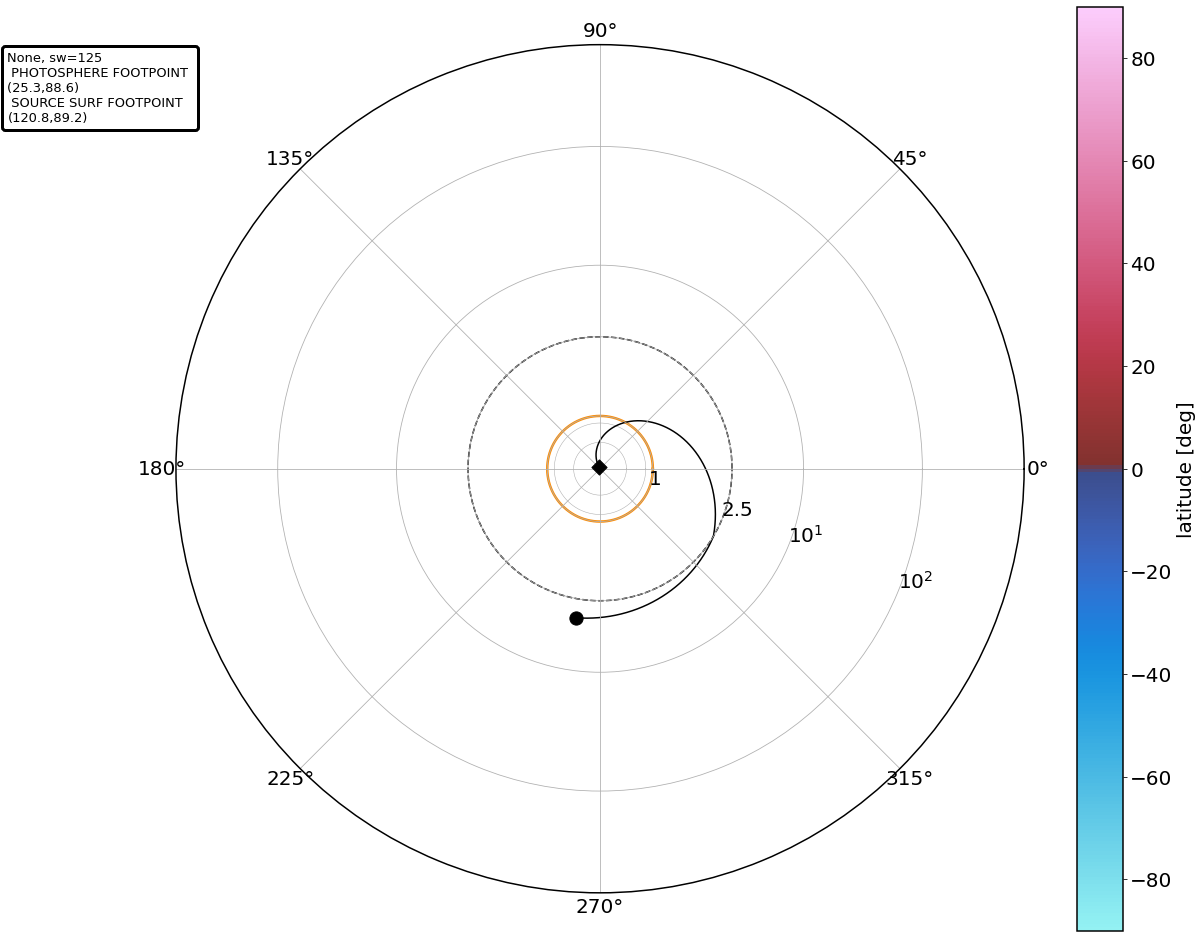

In [50]:
u = [125]
d = [180e6]
lon = [260.7]
lat = [89.2]

flines = symlog_pspiral(u, d, lon, lat, hmimap=output, 
                        vary=False, n_varies=5,
                        save=False)


In [7]:
def field_line_accuracy(flines):
    '''
    Calculates at least now the central point, average distance from the central point and 
    the standard deviation of the photospheric footpoints for a set of field lines
    '''

    if isinstance(flines[0], list):
        flines = flatten(flines)

    footpoints = []
    for fline in flines:
        
        r, lon, lat = get_coord_values(fline)
        
        #index 0 of coordinates corresponds to photospheric coordinates, index -1 to pfss
        footpoint = [lon[0], lat[0]]
        footpoints.append(footpoint)
        
    #declare longitudes and latitudes of footpoints
    footp_lons = [pair[0] for pair in footpoints]
    footp_lats = [pair[1] for pair in footpoints]

    #if separation in longitudes is over half a circle, then points are probably
    #scattered near the 0-deg line -> transfer them far enough from that line
    #while calculations are ran
    if max(footp_lons) > min(footp_lons)+180.0:

        #transfer of longitudes
        footp_lons = shift_longitudes(footp_lons)
        
        #calculate the central point
        c_point = [np.mean(footp_lons), np.mean(footp_lats)]
        
        #standard deviation of longitudes and latitudes
        lon_std = np.std(footp_lons)
        lat_std = np.std(footp_lats)

        #calculate mean distance from the central point
        dist_sum = 0
        for i in range(len(footp_lons)):

            lon1, lat1 = footp_lons[i], footp_lats[i]
            angular_separation = orthodrome(lon1, lat1, c_point[0], c_point[1])

            #distance is in solar radii
            distance_rs = angular_separation
            dist_sum = dist_sum + distance_rs
        
        #transfer lons and the central point back the same amount that the longitudes were moved
        footp_lons = shift_longitudes(footp_lons, shift=-180.0)
        c_point[0] = c_point[0]-180.0

    else:
        
        #calculate the central point
        c_point = [np.mean(footp_lons), np.mean(footp_lats)]

        #standard deviation of longitudes and latitudes
        lon_std = np.std(footp_lons)
        lat_std = np.std(footp_lats)

        #calculate mean distance from the central point
        dist_sum = 0
        for i in range(len(footp_lons)):

            lon1, lat1 = footp_lons[i], footp_lats[i]
            angular_separation = orthodrome(lon1, lat1, c_point[0], c_point[1])

            #distance is in solar radii
            distance_rs = angular_separation
            dist_sum = dist_sum + distance_rs

    avg_dist = dist_sum/len(footp_lons)


    return footpoints, c_point, avg_dist, [lon_std, lat_std]

#------------------------------------------------------------------------------------

def shift_longitudes(lons, shift=180.0):
    '''
    Shifts the longitudes by <shift> amount
    '''
    if shift>0:
        lons = [lon+shift for lon in lons]
        lons = [lon-360.0 if lon>360 else lon for lon in lons]
    else:
        #if shift is negative, points are likely being moved back to their 
        #original place
        lons = [lon+shift for lon in lons]
        lons = [lon+360.0 if lon<0 else lon for lon in lons]

    return lons

In [9]:
fps, c_point, avg_d, stds = field_line_accuracy(flines)
#print(fps[0])
print(c_point)
print(avg_d)
print(stds)

[140.2125923353526, 29.32757989701487]
0.4668368029532713
[20.095349338553813, 33.69991601129609]


In [106]:
def map_on_surface(fps, c_point, avg_d, shift=None, zoom=None, show_avg_d=False):
    '''
    Plots a really simple 2d representation of fieldline objects' footpoints.
    '''
    
    
    import matplotlib.patches as mpatch

    centre = np.array(c_point)
    fpslons = [item[0] for item in fps]
    fpslats = [item[1] for item in fps]

    if shift is not None:
        fpslons = shift_longitudes(fpslons, shift=shift)
        centre[0] = c_point[0]+shift
        
    fig_tuple = (16,7)
    if zoom is not None:
        fig_tuple = (12,12)

    fig = plt.figure(figsize=fig_tuple)
    ax = plt.subplot()

    ax.scatter(fpslons[0], fpslats[0], c='navy', s=60, label="original footpoint")
    ax.scatter(fpslons[1:], fpslats[1:], c='C0', label="varied footpoints")
    ax.scatter(centre[0], centre[1], c='r', label="avg(lons,lats)")
    
    if show_avg_d:
        avg_d_deg = np.rad2deg(avg_d)
        ax.add_patch(mpatch.Circle((centre[0],centre[1]), avg_d_deg, color='r', lw=0.8, ls='--', fill=False))

    plt.ylim(-90,90)
    plt.xlim(0,360)
    if zoom is not None:
        plt.ylim(centre[1]-zoom/2, centre[1]+zoom/2)
        plt.xlim(centre[0]-zoom/2, centre[0]+zoom/2)

    plt.legend()
    plt.grid("True")
    plt.show()

#------------------------------------------------------------------------------------------------

def map_on_surface2(fps, c_point, avg_d, shift=None, zoom=None, show_avg_d=False):
    
    ss_br = output.source_surface_br
    
    import matplotlib.patches as mpatch

    centre = np.array(c_point)
    fpslons = [item[0] for item in fps]
    fpslats = [item[1] for item in fps]

    if shift is not None:
        fpslons = shift_longitudes(fpslons, shift=shift)
        centre[0] = c_point[0]+shift
        
    fig_tuple = (16,7)
    if zoom is not None:
        fig_tuple = (12,12)

    fig = plt.figure(figsize=fig_tuple)
    #ax = plt.subplot()
    
    if show_avg_d:
        avg_d_deg = np.rad2deg(avg_d)
        #ax.add_patch(mpatch.Circle((centre[0],centre[1]), avg_d_deg, color='r', lw=0.8, ls='--', fill=False))

    #plt.ylim(-90,90)
    #plt.xlim(0,360)
    if zoom is not None:
        plt.ylim(centre[1]-zoom/2, centre[1]+zoom/2)
        plt.xlim(centre[0]-zoom/2, centre[0]+zoom/2)

    colors = pl.cm.jet(np.linspace(0,1,len(fps)))
    fig = plt.figure(figsize=fig_tuple)
    ax = plt.subplot(projection=ss_br)
    ss_br.plot() # Plot the source surface Br map
    ax.plot_coord(output.source_surface_pils[0]) # Plot the polarity inversion line
    plt.colorbar()
    ax.set_title('')

    #ax.scatter(fpslons[0], fpslats[0], c='navy', s=60, label="original footpoint")
    #ax.scatter(fpslons[1:], fpslats[1:], c='C0', label="varied footpoints")
    #ax.scatter(centre[0], centre[1], c='r', label="avg(lons,lats)")
    
    fps_arr = np.array(fps)
    #fps_arr = fps_arr.T
    
    #for i in range(len(fps_arr)):
        #ax.plot_coord(fps_arr[i], '.', color='m', markersize=5)

    #ax.plot_coord(fpslons[0], fpslats[0], color='m', markersize=10, label="original footpoint")
    
    # because we don't have a field line directly at the sc_footp_coord we need to find the closest one (of the open field lines)
    # to trace it down to the photosphere:

    # mark its coordinate at the SS:
    #ss_pos = field_line.coords[field_line.coords.radius==np.nanmax(field_line.coords.radius)]
    #ax.plot_coord(ss_pos, 'o', color='m', markersize=10)
    # mark its coordinate at the photosphere:
    #lower_pos = field_line.coords[field_line.coords.radius==np.nanmin(field_line.coords.radius)]
    #ax.plot_coord(lower_pos, '^', color='m', markersize=10)

    
    #plt.legend()
    plt.grid("True")
    plt.show()


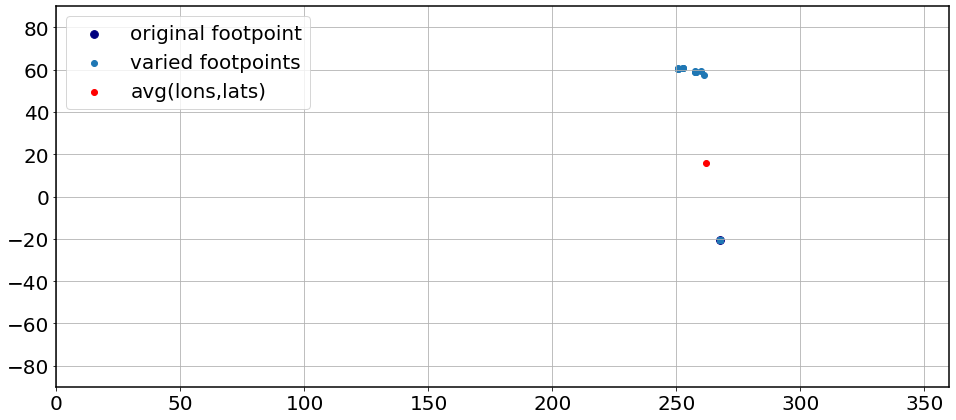

In [114]:
map_on_surface(fps,c_point,avg_d,
               shift=None, zoom=None, show_avg_d=False)

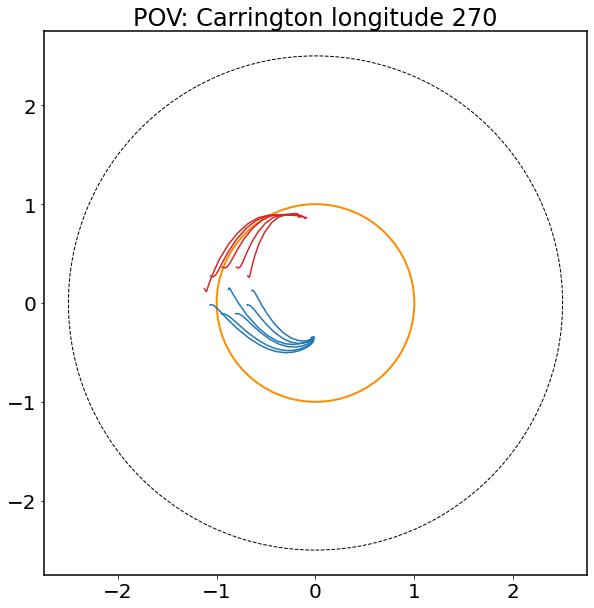

In [67]:
draw_fieldlines(flines, frame='xz', save=False)
#

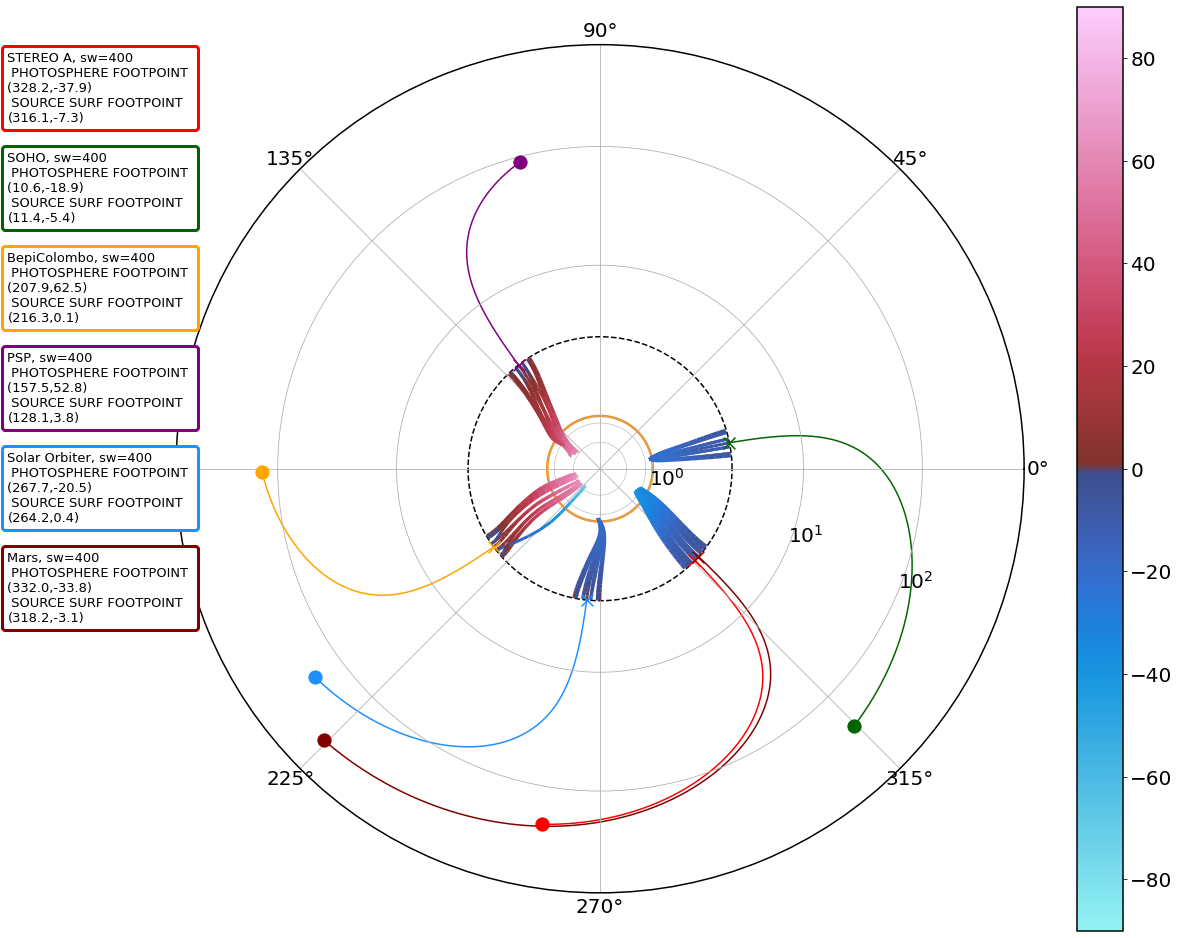

In [56]:
names = ['STEREO A', 'SOHO', 'BepiColombo', 'PSP', 'Solar Orbiter', 'Mars']
u = [400, 400, 400, 400, 400, 400]
d = au_to_km([0.966685164408638, 0.99279049374557, 0.630178489762197, 0.418940858451551, 0.843214100925785, 1.62995044866953])
lon = [260.775740934188, 314.556859144586, 180.524070529599, 104.561372910123, 216.072551543395, 224.562571327842]
lat = [-7.21191748218317, -5.4398280592112, 0.080361095504042, 3.76153510535719, 0.395639095125699, -3.14919334311625]

#
flines = symlog_pspiral(u, d, lon, lat, hmimap=output, names=names, 
                        vary= True, n_varies=10,
                        save=False)
#

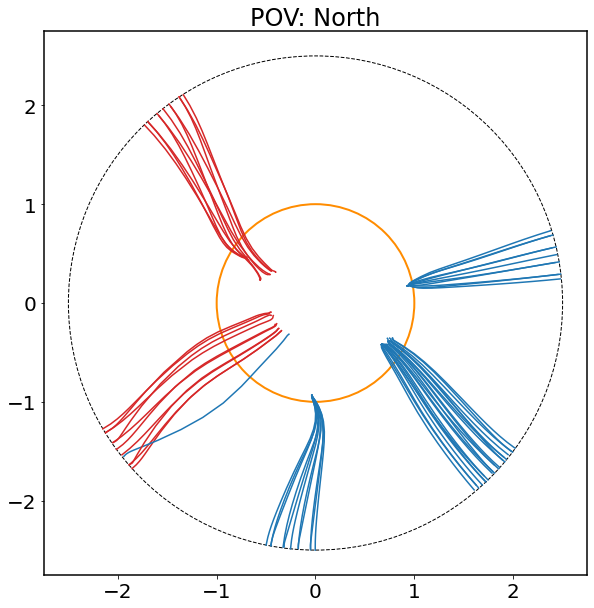

In [63]:
draw_fieldlines(flines, frame='xy')
#

<IPython.core.display.Javascript object>


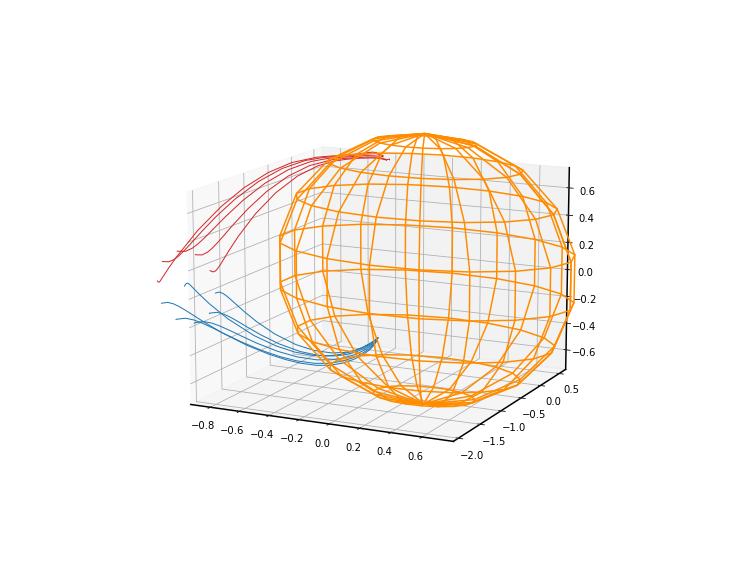

In [68]:
%matplotlib notebook
plot3d(flines)

In [69]:
%matplotlib inline
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 20
plt.rcParams['agg.path.chunksize'] = 20000

In [20]:
def compute_pfss(gong_fname, dtime):

    gong_map = sunpy.map.Map(gong_fname)
    br = gong_map.data
    header = gong_map.meta

    br = br - np.mean(br)
    br = np.roll(br, header['CRVAL1'] + 180, axis=1)
    header['CRVAL1'] = 180
    header['DATE_ORI'] = header['DATE']
    header['date-obs'] = Time(dtime).isot

    gong_map = sunpy.map.Map(br, header)
    nrho = 60
    rss = 2.5

    inputt = pfsspy.Input(gong_map, nrho, rss)
    ssfile = gong_fname.with_suffix('.ssmap')

    if ssfile.exists():
        ssmap = np.loadtxt(ssfile)
        ssmap = sunpy.map.Map(ssmap, header)
    else:
        print('Calculating PFSS solution')
        # Compute PFSS solution and source surface map
        output = pfsspy.pfss(inputt)
        ssdata = output.source_surface_br.data
        np.savetxt(ssfile, ssdata)
        ssmap = output.source_surface_br

    return inputt, ssmap


def trace(map_file, psp_coord, pfss_input, retrace=False):
    '''
    INPUT
    map_file: file of field lines, format = .fline
    psp_coord: pair of coordinates [lon, lat]
    pfss_input: 
    retrace:
    
    OUTPUT
    an open field line connecting to (?)
    '''
    # Load field line
    #fline_file = map_file.with_suffix('.fline')
    #if fline_file.exists() and not retrace:
        #fline = load_fline(fline_file)
    if 5 == '5':
        pass
    else:
        print('Tracing field line')
        # Calculate field line

        output = pfsspy.pfss(pfss_input)
        tracer = pfsspy.tracing.PythonTracer()
        fline = tracer.trace(psp_coord, output)[0].coords
        if not retrace:
            fline_xyz = np.array([fline.x / u.m, fline.y / u.m, fline.z / u.m])
            np.savetxt(fline_file, fline_xyz)

    fline.representation_type = 'spherical'
    lon = fline.lon.to_value(u.deg)
    lat = fline.lat.to_value(u.deg)
    r = fline.radius.to_value(u.m)
    lon, lat, r = insert_nans(lon, lat, r)

    fline = SkyCoord(lon * u.deg, lat * u.deg, r * u.m, frame='heliographic_carrington', obstime=fline.obstime)

    return fline


In [24]:
'''
series = a.jsoc.Series('hmi.synoptic_mr_polfil_720s')
crot = a.jsoc.PrimeKey('CAR_ROT', cr)
result = Fido.search(time, series, crot, a.jsoc.Notify("chospa@utu.fi"))
files = Fido.fetch(result)
hmi_map = sunpy.map.Map(files[0])                    #HMI MAP HERE
pfsspy.utils.fix_hmi_meta(hmi_map)
print('Data shape: ', hmi_map.data.shape)
hmi_map = hmi_map.resample([360, 180]*units.pix)
print('New shape: ', hmi_map.data.shape)             #HMI MAP RESAMPLED TO LOWER RESOLUTION
pfsspy_input = pfsspy.Input(hmi_map, nrho, rss)
output = pfsspy.pfss(pfsspy_input)                   #THE SOURCE SURFACE SOLUTION
'''

'\nseries = a.jsoc.Series(\'hmi.synoptic_mr_polfil_720s\')\ncrot = a.jsoc.PrimeKey(\'CAR_ROT\', cr)\nresult = Fido.search(time, series, crot, a.jsoc.Notify("chospa@utu.fi"))\nfiles = Fido.fetch(result)\nhmi_map = sunpy.map.Map(files[0])\npfsspy.utils.fix_hmi_meta(hmi_map)\nprint(\'Data shape: \', hmi_map.data.shape)\nhmi_map = hmi_map.resample([360, 180]*units.pix)\nprint(\'New shape: \', hmi_map.data.shape)\npfsspy_input = pfsspy.Input(hmi_map, nrho, rss)\noutput = pfsspy.pfss(pfsspy_input)\n'

In [4]:
def get_pfss_fline(lon, lat, ngrid, cr, nrho, date, r_s):
    '''
    INPUT
    lon = longitude of sc footpoint [deg]
    lat latitude of sc footpoint [deg]
    ngrid = vertical grid, how many elements in a field line
    cr = carrington rotation
    nrho = 
    date = [YYYY/MM/DD]
    r_s = height of source surface in solar radii
    
    RETURNS
    fline = coordinates of the open field line which comes closest to sc footpoint on source surface
    '''

    time = a.Time(date, date)

    pfname =  f'/home/chospa/solar_mach/pfss/PFSS_fieldlines_grid_{ngrid}_{time.start.datetime.date()}_CR{cr}_SS{r_s}_nrho{nrho}.p'
    try:  # check if fieldlines file exists
        with open(pfname, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            field_lines = u.load()
        print('Found pickled PFSS fieldlines file')

    #if not existent, calculate field lines, and save as pickle file for next time
    except FileNotFoundError:
        tracer = tracing.PythonTracer()
        r = 1.5*const.R_sun
        lat0 = np.linspace(-np.pi / 2, np.pi / 2, ngrid, endpoint=False)
        lon0 = np.linspace(0, 2*np.pi, ngrid, endpoint=False)
        lat1, lon1 = np.meshgrid(lat0, lon0, indexing='ij')
        lat, lon = lat1.ravel()*units.rad, lon1.ravel()*units.rad
        seeds = SkyCoord(lon, lat, r, frame=output.coordinate_frame)
        field_lines = tracer.trace(seeds, output)
        with open(pfname, 'wb') as f:
            pickle.dump(field_lines, f)

    #get all the open field lines
    open_lines = field_lines[field_lines.polarities != 0]

    #list all open field lines and their coordinates:
    field_line_pol = []
    ss_pos_lons = []
    ss_pos_lats = []
    coords_list = []
    for i, field_line in enumerate(open_lines):
        coords = field_line.coords
        ss_pos = coords[coords.radius==np.nanmax(coords.radius)]
        ss_pos_lons.append(ss_pos.lon.value[0])    # longitudes of the open field lines at the SS
        ss_pos_lats.append(ss_pos.lat.value[0])    # latitudes of the open field lines at the SS
        field_line_pol.append(field_line.polarity)  # polarities of the open field lines
        coords_list.append(coords)

    ss_pos_lons = np.array(ss_pos_lons)
    ss_pos_lats = np.array(ss_pos_lats)
    field_line_pol = np.array(field_line_pol)

    #coordinates of the sc footpoint at SS    
    sc_footp_coord = SkyCoord([lon*units.deg], [lat*units.deg], [r_s*units.R_sun], frame=frames.HeliographicCarrington, obstime=ss_pos.obstime, observer=ss_pos.observer)
    
    #get the magn. polarity at the region of the sc footpoint, simply put it's the sign of Br component
    pol_sc_footp = np.sign(output.get_bvec(sc_footp_coord)[0][0])
    
    #index of all open field lines with the same polarity like the one of sc_footp_coord
    pol_ind = np.where(field_line_pol == pol_sc_footp)[0]

    #if and when no field line connects to exactly the footpoint of the spiral arm, find the closest one to it
    total_sep_angles = orthodrome(lon, lat, ss_pos_lons[pol_ind], ss_pos_lats[pol_ind], rad=False)
    ind = np.where(total_sep_angles == np.nanmin(total_sep_angles))[0]

    #this is the fieldline we trace down
    field_line = open_lines[pol_ind][ind[0]]

    #this contains the coordinates of the whole field line from SS to photosphere
    fline = field_line.coords

    return fline


In [19]:
def inside_pfss(ss_footpoint, field_line_coords, backtracked_object, r_s=2.5, resolution=1000, save=False):
    '''
    ss_footpoint = carrington longitude, latitude (coordinates on source surface sphere)
    field_line = field line object, lons, lats, height
    backtracked_object = list of [solar wind speed in km/s, distance, longitude, latitude]
    r_s = source surface of the potential field, type: float
    resolution = resolution of the curve, type: int
    save = boolean value to save the figure
    '''
    from matplotlib import cm

    sun_radius = const.R_sun.value  #/ 10**6 #m

    #normalize height to solar radii + declare lon and lat
    fl_r = field_line_coords.radius.value / sun_radius
    fl_lon = field_line_coords.lon.value
    fl_lat = field_line_coords.lat.value

    #source surface:
    theta = 2*np.pi*np.linspace(0,1,resolution)
    ss = np.ones(resolution)*r_s

    #Plotting commands-->
    fig, ax = plt.subplots(figsize = [15,15], subplot_kw={'projection': 'polar'})

    #plot the source_surface and solar surface
    ax.plot(theta, ss, c='k', ls='--')
    ax.plot(theta, np.ones(resolution), c='darkorange', lw=2.5)

    #initialize colorbar:
    cmap = cm.viridis #seismic

    #plot a field line connecting ss_footpoint and the solar surface
    ax.scatter(np.deg2rad(ss_footpoint[0]),r_s, s=130, c='darkorange', marker='x')
    fieldline = ax.scatter(np.deg2rad(fl_lon), np.cos(np.deg2rad(fl_lat))*fl_r, c=fl_lat, cmap=cmap, vmin=-90, vmax=90)

    ax.set_rscale('symlog', linthresh=r_s)
    ax.set_rmax(5) #200e6/sun_radius

    ax.grid(True)
    #ax.set_thetamin(0)
    #ax.set_thetamax(225)
    ax.set_rticks([])  # [0.1, 1.0, 10.0] Less radial ticks
    #ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line

    #plt.legend(loc=1, bbox_to_anchor=(1.2, 1.0))

    fig.colorbar(fieldline)

    if(save):
        plt.savefig('fieldline_follow.png', transparent=False, bbox_inches='tight')

    plt.show()

    print("footpoint on source surface ({},{})".format(np.round(fl_lon[0]),np.round(fl_lat[0])))
    print("footpoint on solar surface ({},{})".format(np.round(fl_lon[-1]),np.round(fl_lat[-1])))


In [11]:

def get_pfss_hmimap(filepath, email, carrington_rot, date, rss=2.5, nrho=35):
    '''
    downloading hmi map or calculating the PFSS solution
    '''

    time = a.Time(date, date)
    pfname =  filepath+"PFSS_output_"+ str(time.start.datetime.date())+'_CR'+str(carrington_rot)+'_SS'+str(rss)+'_nrho'+str(nrho)+'.p'

    #check if PFSS file already exists locally:
    try:
        with open(pfname, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            output = u.load()
        print('Found pickled PFSS file')

    #if not, then download MHI mag, calc. PFSS, and save as picle file for next time
    except FileNotFoundError:
        series = a.jsoc.Series('hmi.synoptic_mr_polfil_720s')
        crot = a.jsoc.PrimeKey('CAR_ROT', carrington_rot)
        result = Fido.search(time, series, crot, a.jsoc.Notify(email))
        files = Fido.fetch(result)
        hmi_map = sunpy.map.Map(files[0])
        pfsspy.utils.fix_hmi_meta(hmi_map)
        print('Data shape: ', hmi_map.data.shape)

        hmi_map = hmi_map.resample([360, 180]*units.pix)
        print('New shape: ', hmi_map.data.shape)

        pfss_input = pfsspy.Input(hmi_map, nrho, rss)
        output = pfsspy.pfss(pfss_input)
        with open(pfname, 'wb') as f:
            pickle.dump(output, f)

    return output

In [12]:
filepath="/home/chospa/solar_mach/pfss/"
email = "chospa@utu.fi"
carrington_rot = 2243
date = '2021/4/17'

hmimap = get_pfss_hmimap(filepath, email, carrington_rot, date)

Found pickled PFSS file


In [13]:
hmimap

In [21]:
u = [400, 400]
d = [150e6, 180e6]
lon = [180, 45]
lat = [-2, 3]

#
flines = symlog_pspiral(u, d, lon, lat, hmimap=hmimap, save=False)


NameError: name 'hmimap' is not defined